In [1]:
import pandas as pd 
import psutil
import json
import matplotlib.pyplot as plt
import functions as f 

In [2]:
PATH = 'realKnownCause/ec2_request_latency_system_failure.csv'
ERRORPATH = 'labels/combined_labels.json'


# load data 
df = pd.read_csv(PATH,  parse_dates=['timestamp'])
# load error data
with open(ERRORPATH, "r") as file:
    errors = json.load(file)
df_error = errors.get(PATH)

# Visualise data 

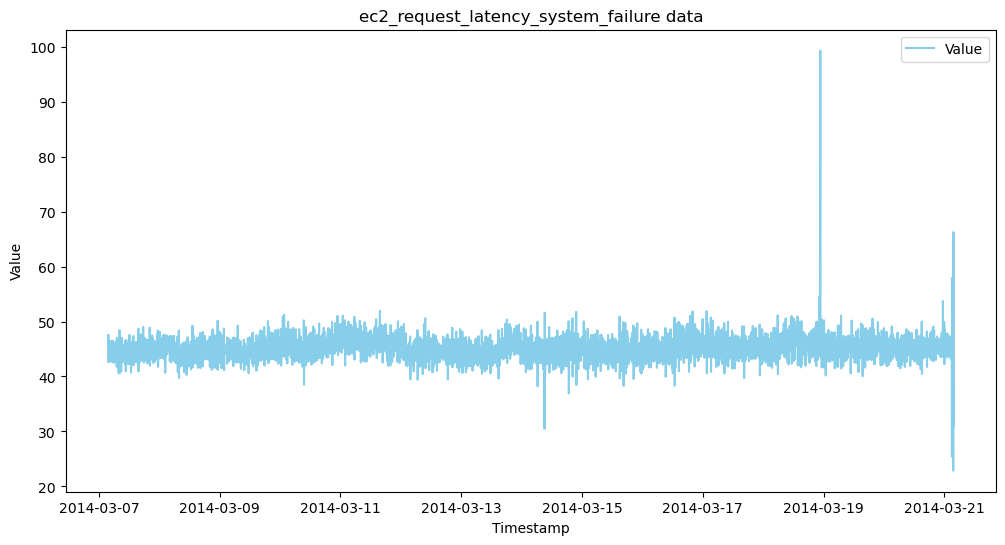

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Value', color='skyblue')
plt.title('ec2_request_latency_system_failure data')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.savefig('images/ec2_overview.png')
plt.show()


# Check time gap

timestamp
0 days 00:05:00    4017
0 days 00:00:00      11
0 days 01:04:00       1
0 days 00:01:00       1
0 days 00:10:00       1
Name: count, dtype: int64


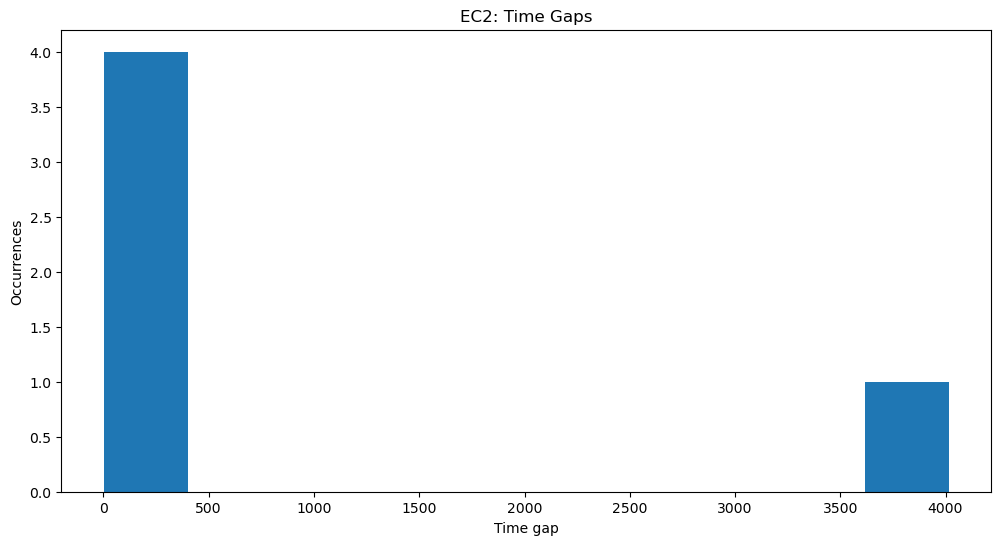

In [12]:
# Calculate time differences between consecutive timestamps
time_diff = df['timestamp'].diff()
print(time_diff.value_counts())


# Visualize time gaps
plt.figure(figsize=(12, 6))
plt.hist(time_diff.value_counts())
#plt.plot(df['timestamp'], time_diff.dt.total_seconds(), marker='o')
plt.title('EC2: Time Gaps')
plt.ylabel('Occurrences')
plt.xlabel('Time gap')
plt.savefig('images/ec2_timegap.png')
plt.show()


To avoid this problem, propose function process_time_series. Redo the whole process.

In this new process, 
* data must be sorted first in an ascending order, meaning the timestamp must increase over time.
* define the most frequent interval in the dataset
* the dataset will be grouped based on the found interval

Refer to process_time_series function in functions.py

Furthermore, if there exists NA value after groupping, using linear interpolation to fill the NaN value. Linear interpolation is applied based on the assumption that data should change overtime. 

# Check duplicates

In [13]:
# Identify duplicates
duplicates = df.duplicated('timestamp', keep=False)

# Print duplicates
print('Duplicates are:')
print(df[duplicates])

Duplicates are:
              timestamp   value
556 2014-03-09 03:00:00  44.612
557 2014-03-09 03:00:00  43.578
558 2014-03-09 03:00:00  47.018
559 2014-03-09 03:00:00  46.456
560 2014-03-09 03:00:00  44.368
561 2014-03-09 03:00:00  43.544
562 2014-03-09 03:00:00  44.938
563 2014-03-09 03:00:00  43.834
564 2014-03-09 03:00:00  47.026
565 2014-03-09 03:00:00  42.368
566 2014-03-09 03:00:00  44.468
567 2014-03-09 03:00:00  47.090


# Check monotonic

In [28]:
df['timestamp'].is_monotonic_increasing

True

In [15]:
df.describe()

,timestamp,value
count,4032,4032.000000
mean,2014-03-14 03:40:14.434523648,45.155874
min,2014-03-07 03:41:00,22.864000
25%,2014-03-10 15:39:45,43.944000
50%,2014-03-14 03:38:30,45.017000
75%,2014-03-17 15:42:15,46.362000
max,2014-03-21 03:41:00,99.248000
std,NaN,2.287089


# New process

In [12]:
df = pd.read_csv(PATH,  parse_dates=['timestamp'])
# Apply process_time_series, resampled dataset and also apply linear interpolation 
def process_time_series(df, grouping=True):
    # Ensure the timestamps are sorted
    if not df['timestamp'].is_monotonic_increasing:
        df = df.sort_values(by='timestamp')
    
    # Calculate time differences
    time_diff = df['timestamp'].diff().dt.total_seconds()
    
    # Count the occurrences of each time difference
    time_diff_counts = time_diff.value_counts()
    
    # Get the most frequent time difference
    most_frequent_diff = time_diff_counts.idxmax()
    
    # Convert time_diff to a frequency string
    freq_str = f'{most_frequent_diff}s'

    if grouping:
        # Resample the dataset to the most frequent time difference
        df_resampled = df.set_index('timestamp').resample(freq_str).asfreq()
        
        # Reset index to make 'timestamp' a column again
        df_resampled = df_resampled.reset_index()
        
        # Group by timestamp and calculate the mean value
        df_grouped = df_resampled.groupby('timestamp').mean().reset_index()
        
        df = df_grouped
    
    return most_frequent_diff, df
time_diff, df = process_time_series(df, grouping=True)

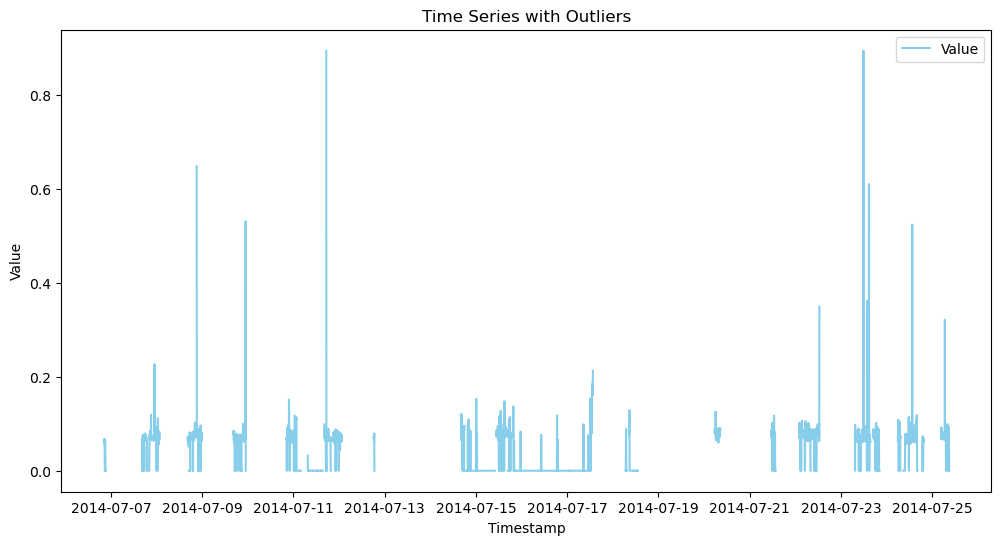

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['value'], label='Value', color='skyblue')
plt.title('Time Series with Outliers')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()


# realKnownCause folder

In [38]:
PATH = 'realKnownCause/'
ERRORPATH = 'labels/combined_windows.json'

def process_time_series(df):
    # Ensure the timestamps are sorted
    if not df['timestamp'].is_monotonic_increasing:
        df = df.sort_values(by='timestamp')
    
    # Calculate time differences
    time_diff = df['timestamp'].diff().dt.total_seconds()
    
    # Count the occurrences of each time difference
    time_diff_counts = time_diff.value_counts()
    
    # Get the most frequent time difference
    most_frequent_diff = time_diff_counts.idxmax()
    
    # Convert time_diff to a frequency string
    freq_str = f'{most_frequent_diff}s'
    
    return most_frequent_diff

In [39]:
file_names = f.get_all_files(PATH)
all_csv = [f.read_csv_file(csv) for csv in file_names]
time_diffs = [process_time_series(csv) for csv in all_csv]

In [42]:
pd.DataFrame({
    'name': [file.strip('realKnownCuase/') for file in file_names],
    'timegap': time_diffs
})

,name,timegap
0,yc_taxi.csv,1800.0
1,gue_agent_key_hold.csv,300.0
2,cpu_utilization_asg_misconfiguration.csv,300.0
3,gue_agent_key_updown.csv,300.0
4,mbient_temperature_system_failure.csv,3600.0
5,machine_temperature_system_failure.csv,300.0
6,c2_request_latency_system_failure.csv,300.0


In [34]:
len(time_diffs)

0